/Users/kirillklimushin/Desktop/deepfake_detection/df_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kirillklimushin/Desktop/deepfake_detection/df_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


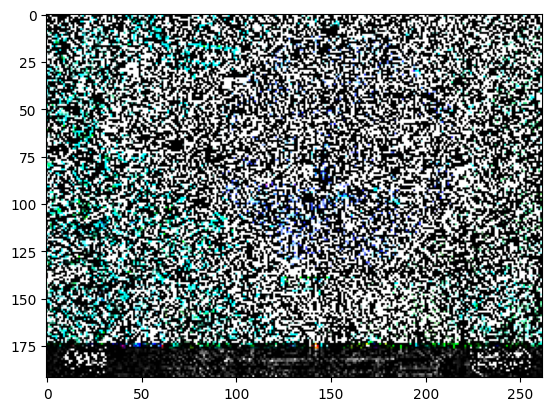

In [1]:
import numpy 
import torch
from torch import nn
import typing
import cv2

def compute_gradient(model: nn.Module, img: torch.Tensor, loss: typing.Callable, target: int):
    """
    Function returns
    """
    img.requires_grad = True
    logit = model(img)[0, target]
    logit.backward()
    img.requires_grad = False
    return img.grad.data.squeeze(0)
    
def normalize_gradient(img: torch.Tensor, percentile: float):
    if percentile > 1.0 or (percentile < 0):
        raise ValueError(msg='invalid percentile')
    return img / numpy.percentile(a=img.numpy(), q=percentile)

def get_baseline(input_img: numpy.ndarray, baseline_type, **kwargs):

    if baseline_type == 'black':
        return numpy.zeros_like(input_img).astype(numpy.uint8)

    if baseline_type == 'gaussian':
        return numpy.asarray(cv2.GaussianBlur(
            input_img, 
            sigmaX=kwargs.get("sigmaX", 2),
            sigmaY=kwargs.get("sigmaY", 2)
        ))
    raise ValueError('invalid baseline type.')

def integrated_gradients(
    network: nn.Module,
    input_img: numpy.ndarray, 
    actual_label: int,
    loss_function: nn.Module,
    n_steps: int, 
    baseline_type: typing.Literal['gaussian', 'black']
):
    baseline = torch.from_numpy(get_baseline(input_img, baseline_type)).permute(2, 0, 1).unsqueeze(0)
    input_img = torch.from_numpy(input_img.astype(numpy.uint8)).permute(2, 0, 1).unsqueeze(0)

    path = [baseline + alpha * (input_img - baseline) for alpha in numpy.linspace(0, 1, num=n_steps)]
    grads = [compute_gradient(model=network, img=img, loss=loss_function, target=actual_label) for img in path]
    norm_grads = [normalize_gradient(grad, percentile=0.98) for grad in grads[:-1]]
    int_grads = (input_img - baseline) * torch.cat(norm_grads[:-1]).mean(axis=0, keepdim=True)
    return int_grads.squeeze(0).permute(1, 2, 0)

import matplotlib.pyplot as plt
import torchvision.models 

img = cv2.imread("../test_input_2.jpeg", cv2.IMREAD_UNCHANGED).astype(numpy.uint8)
model = torchvision.models.resnet18(pretrained=True)
model.eval()

grads = integrated_gradients(
    network=model,
    input_img=img, 
    actual_label=1, 
    loss_function=nn.CrossEntropyLoss(), 
    n_steps=100,
    baseline_type='black',
)

plt.imshow(grads)